## Introduction

Linear regression is a popular supervised machine learning algorithm that predicts a target given some predictors. In this lesson, we'll cover how to fit a linear regression model using a technique called gradient descent.  Both linear regression and gradient descent are key building blocks for neural networks, and we'll build on this in future neural network tutorials.

We'll use linear regression to predict tomorrow's temperature using historical data:

In [44]:
import pandas as pd

data = pd.read_csv("../data/clean_weather.csv", index_col=0)
# Fill in any missing values in the data with past value
data = data.ffill()

data.head(5)

,tmax,tmin,rain,tmax_tomorrow
1970-01-01,60.0,35.0,0.0,52.0
1970-01-02,52.0,39.0,0.0,52.0
1970-01-03,52.0,35.0,0.0,53.0
1970-01-04,53.0,36.0,0.0,52.0
1970-01-05,52.0,35.0,0.0,50.0


Using the data above, we could predict `tmax_tomorrow` based on today's max temperature (`tmax`), today's min temperature (`tmin`), and how much it rained today (`rain`).

Linear regression requires a linear relationship between the predictors and the target.  If two values have a linear relationship, when one value increase, another value changes proportionally:

<AxesSubplot: xlabel='tmax', ylabel='tmax_tomorrow'>

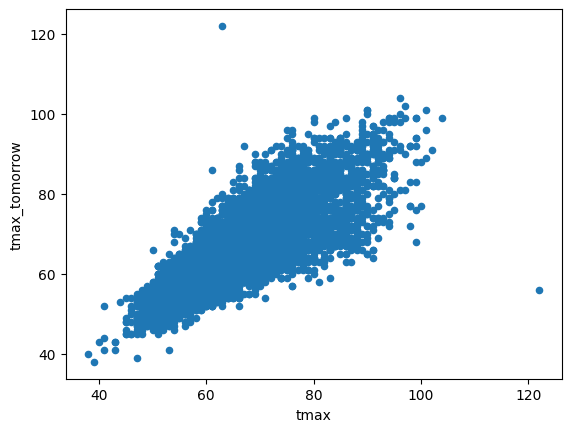

In [45]:
data.plot.scatter("tmax", "tmax_tomorrow")

As you can see above, `tmax` and `tmax_tomorrow` have a linear relationship - when `tmax` increases, `tmax_tomorrow` usually does as well.  Since `tmax` is linearly related to `tmax_tomorrow`, we can multiply `tmax` by a value to get a prediction for`tmax_tomorrow`.

This is exactly what linear regression does - it learns the correct values to multiply the predictors by to get the target.  The equation for this looks like:

$\hat{y}=w_{1}x_{1} + w_{2}x_{2} + w_{3}x_{4} + b$

- $\hat{y}$ is our prediction for `tmax_tomorrow`.
- $x_{1}$, $x_{2}$, and $x_{3}$ are the predictors that we're using to predict the target (in this case, `tmax`, `tmin`, and `rain`).  If we had more predictors, we would add more x values to our equation.
- The $w$ values are the weight parameters that the linear regression algorithm learns.  The weights are what we multiply the $x$ values by to get the predicted $\hat{y}$ value.
- $b$ is a value called the bias (or y-intercept).  This enables us to "shift" the prediction line up or down to match the data.  Without a bias, if our predictors are all `0`, then our prediction will also be `0`.

Let's take a look at how a linear regression model works.  To simplify things, we will go with just a single predictor (`tmax`).

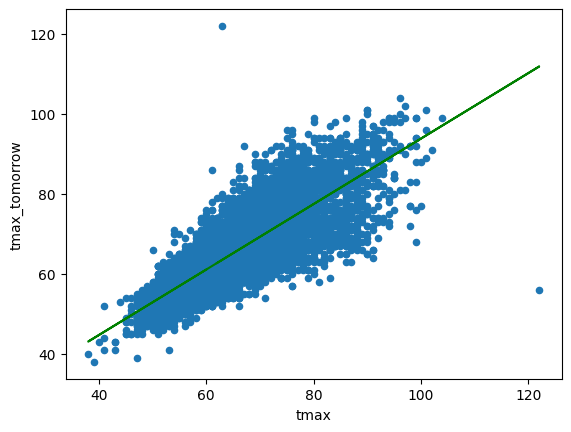

In [46]:
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# Fit a linear regression model
lr = LinearRegression()
lr.fit(data[["tmax"]], data["tmax_tomorrow"])

# Plot our data points and the regression line
data.plot.scatter("tmax", "tmax_tomorrow")
plt.plot(data["tmax"], lr.predict(data[["tmax"]]), color="green")

In the above cell, we fit a linear regression model using a library called `scikit-learn`.  The data points are in blue, and the linear regression line (predicted temperatures) is in green.

We can take a look at the coefficients for the line below:

In [47]:
print(f"Weights: {lr.coef_[0]:.2f}")
print(f"Bias: {lr.intercept_:.2f}")

Weights: 0.82
Bias: 11.99


Our predictions will be $\hat{y}=.79 * \text{tmax} + 14.07$.  Now let's learn how to build our own linear regression algorithm.

Earlier, I mentioned that we'd train our linear regression algorithm using gradient descent.  To make gradient descent work, we first need to calculate our loss.

Let's say today's maximum temperature is `80`.  Using the equation, we can calculate tomorrow's predicted temperature to be `77.27`. Then we can calculate our loss.  Loss is the difference between the actual values and our predictions.  We can use squared error for our loss metric, and calculate it using the formula $e=(\hat_{y} - y) ^ 2$.  Our loss is $(80 - 77.27) ^ 2$, which equals `7.45`.

Our parameters (weight and bias) led to this loss value.  It's possible that if we changed our weight, our loss would decrease.  For other values of our weight, loss could increase.

Let's visualize what it would look like if our weight value was `1`.


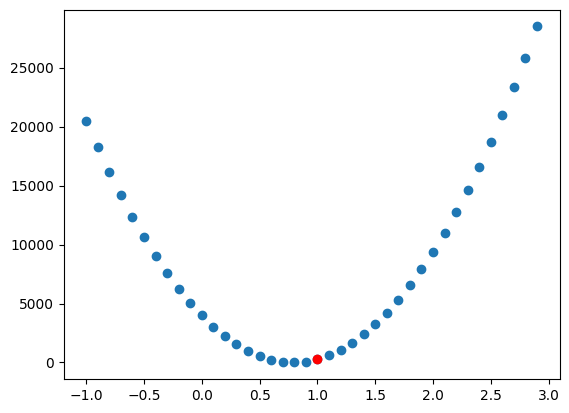

In [48]:
import numpy as np
# Calculate loss values for several weights
ws = np.arange(-1,3,.1)
losses = ((ws * 80 + 14.07) - 77.27) ** 2

# Plot the weight and losses
plt.scatter(ws, losses)
plt.plot(1, 282.24, 'ro')

In the plot above, we've graphed the weight values on the x-axis, and the corresponding losses on the y-axis.  As you can see, there is a value where loss is the lowest.  Loss increases if the weight is higher or lower than that value.  This is called the global minimum, and it's our goal to reach this value.

 Let's say our weight is `1`, and we want to decide whether to increase or decrease the weight to reduce loss.  We've marked the point where the weight equals `1` in red.

This is where gradient descent comes into play - it helps us adjust our parameters to reduce loss.

First, we calculate the loss when the weight is `1`.  This equals `282.24` ($(1 * 80 + 14.07 - 77.27) ^ 2$).  We then have to figure out how much each parameter contributes to that loss.

To understand how we do this, let's first take a look at the operations we perform to get a prediction:

![Operations](images/linreg/gradient.svg)

As you can see, we take our input data (`tmax`), multiply it by the weight $w$, then add in the bias $b$ to get our prediction.

To make the prediction closer to the correct value, we need to adjust $w$ and $b$.  We need to know how much to adjust them, and in which direction (up or down).

To figure this out, we take the partial derivative of the loss against $w$ and $b$.  This is a math way of saying "we're going to figure out how much each parameter contributes to our loss".

We start by calculating the gradient of our loss.  This tells us how quickly our loss is changing.  We want to move in the direction where loss is decreasing the fastest.  We can calculate this by taking the derivative of our loss metric, which is $2 * (\hat{y} - {y})$. This shows us how quickly our loss is changing:

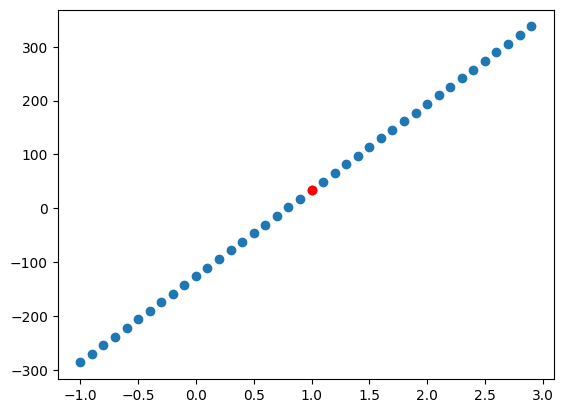

In [49]:
import numpy as np
# Calculate gradient values for several weights
gradients = ((ws * 80 + 14.07) - 77.27) * 2

# Plot the weight and gradients
plt.scatter(ws, gradients)
plt.plot(1, 33.6, 'ro')

If our weight is above a certain value (around `.79`), then our gradient is positive, and our predictions are too large.  If it is below the value, then our gradient is negative, and our predictions are too small.

With gradient descent, our goal is to get to a place where the gradient is close to `0` (our predictions match the actual values).

The partial derivative with respect to the loss tells us how much to adjust each parameter to lower the loss.

First, let's take the partial derivative with respect to $b$:

$\frac{\partial L}{\partial b}=\partial L$

The intuitive way to think about this is "how would I change $b$ if I wanted to get the predictions closer to the actuals?".  Because you add $b$ to $x * w$ to get the prediction, any change to $b$ directly impacts the prediction.  So the partial derivative of $b$ with respect to the loss is the same as the loss!

![B derivative](images/linreg/b_deriv.svg)

Next, we take the partial derivative with respect to $w$.  This is a little more complicated, since we multiply $w$ by $x$, then add it to $b$ to get our prediction:

$\frac{\partial L}{\partial w}=\frac{\partial L}{\partial (x*w)}\frac{\partial (x*w)}{\partial w}$

We use the chain rule to find the derivative.  The chain rule says that the partial derivative of $a$ with respect to $c$ equals the partial derivative of $a$ with respect to $b$ times the partial derivative of $b$ with respect to $c$.

Similar to what we saw with $b$, $\frac{\partial L}{\partial (x*w)}$ is just the same as $\partial L$, since we add it to $b$ to get the loss.

So we can update the equation to:

$\frac{\partial L}{\partial w}=\partial L\frac{\partial (x*w)}{\partial w}$

Since we multiply $w$ by $x$, any change to $w$ will change the prediction proportional to $x$.  So:

$\frac{\partial L}{\partial w}=\partial L * x$

![W derivative](images/linreg/w_deriv.svg)

After calculating the partial derivatives, we update our $w$ and $b$ values by subtracting the partial derivatives.  We don't want to subtract the entire partial derivative, though - this would change the weight too much:

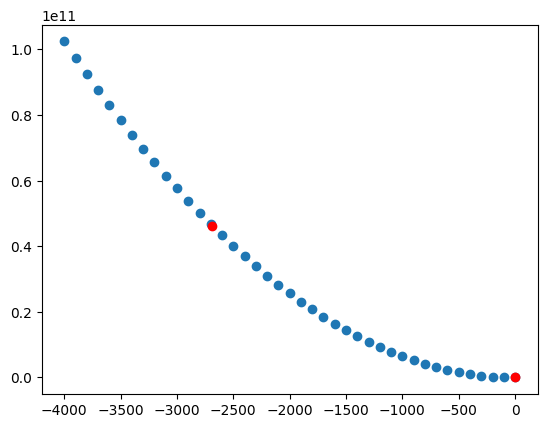

In [50]:
ws = np.arange(-4000,100,100)
losses = ((ws * 80 + 14.07) - 77.27) ** 2

# Plot the weight and losses
plt.scatter(ws, losses)

# Original weight
plt.plot(1, 33.6, 'ro')
# New weight
new_weight = 1-2688
plt.plot(new_weight, (new_weight * 80 + 14.07 - 77.27) ** 2, 'ro')

Above, you can see the original weight on the right - the error is actually lower than with the new weight, which is at the left.  This is because we took too large of a step.  This is a common problem with gradient descent - we adjust our parameters so much that we overshoot the minimum and end up with higher error.

To adjust for this, we use a learning rate.  Instead of adjusting the weights and biases directly by the partial derivative, we multiply by the learning rate.

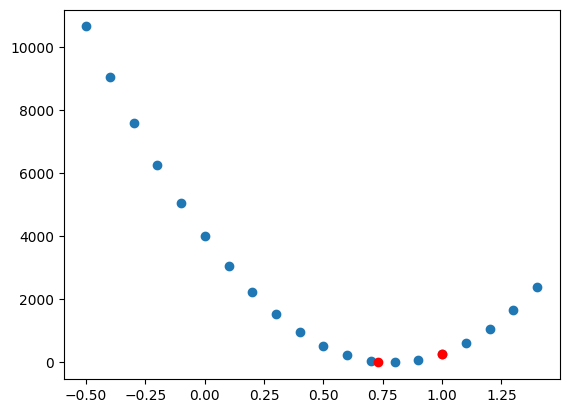

In [51]:
ws = np.arange(-.5,1.5,.1)
losses = ((ws * 80 + 14.07) - 77.27) ** 2

# Plot the weight and losses
plt.scatter(ws, losses)

# Original weight
plt.plot(1, 282.24, 'ro')
# New weight with learning rate
lr = 1e-4
new_weight = 1 - lr * 2688
plt.plot(new_weight, (new_weight * 80 + 14.07 - 77.27) ** 2, 'ro')

The new weight is around `.75`, and has lower error than the original weight of `1`.  We repeat gradient descent multiple times to "descend" to the correct weight and bias values.

We now know everything we need to implement linear regression with gradient descent!  Let's dive in.

Let's first load our data and split it into 3 sets:

- A training set, which we'll use to train our algorithm
- A validation set, which we'll use to measure error during training
- A test set, which we'll use to evaluate the model after it has been fit

Creating separate sets like this helps us avoid overfitting, where our model looks great in training, but doesn't work in the real world.

In [52]:
import numpy as np
PREDICTORS = ["tmax", "tmin", "rain"]
TARGET = "tmax_tomorrow"

# Ensure we get the same split every time
np.random.seed(0)

split_data = np.split(data, [int(.7 * len(data)), int(.85 * len(data))])
(train_x, train_y), (valid_x, valid_y), (test_x, test_y) = [[d[PREDICTORS].to_numpy(), d[[TARGET]].to_numpy()] for d in
                                                            split_data]

To train a linear regression algorithm using gradient descent, we need 4 elements:

- A way to initialize our parameters (weights and biases)
- A `forward` pass that computes predictions using the parameters
- A loss function that measures the error of our predictions
- A `backward` pass that updates our parameters to reduce the loss

To initialize our parameters, we can use random initialization.  But we'll shrink the values so we don't end up with predictions that are too large. Random initialization helps the gradient descent algorithm get to the correct values (feel free to experiment with other initializations, like 0 or 1 to see what happens).

In [53]:
import math

def init_params(predictors):
    k = math.sqrt(1 / predictors)
    np.random.seed(0)
    weights = np.random.rand(predictors, 1) * 2 * k - k
    biases = np.ones((1, 1)) * 2 * k - k
    return  [weights, biases]

We initialize one $w$ value for each of our predictors (`tmax`, `tmin`, and `rain`).  We initialize one bias for each output variable.

In the forward pass of our network, we generate predictions by multiplying $w$ and $x$, then adding $b$:

In [54]:
def forward(params, x):
    weights, biases = params
    prediction = x @ weights + biases
    return prediction

Once we have predictions, we need to calculate error.  We have two functions, one to calculate the loss, and one to calculate the loss gradient (when we update our parameters):

In [55]:
def mse(actual, predicted):
    return np.mean((actual - predicted) ** 2)

def mse_grad(actual, predicted):
    return predicted - actual

In the backward pass of the network, we adjust $w$ and $b$ by the partial derivative times learning rate.  We will make predictions for our whole training set, then average the gradient across the whole set to compute the updates.  This will ensure that a single training example doesn't pull the gradient too far in one direction or another.  It ensures that the descent will be stable.

In [56]:
def backward(params, x, lr, grad):
    w_grad = (x.T / x.shape[0]) @ grad
    b_grad = np.mean(grad, axis=0)

    params[0] -= w_grad * lr
    params[1] -= b_grad * lr

    return params

Finally, we'll write a loop that:

- Makes predictions for the whole training set
- Computes the gradient for each training example
- Updates the parameters based on the gradient

We will run the algorithm for several epochs - an epoch is each iteration over the training set.  Up to a point, more epochs will improve the accuracy.

We will print out the loss on the validation set regularly so we can monitor the loss.

In [57]:
lr = 1e-4
epochs = 50000
params = init_params(train_x.shape[1])

for i in range(epochs):
    predictions = forward(params, train_x)
    grad = mse_grad(train_y, predictions)

    params = backward(params, train_x, lr, grad)

    if i % 10000 == 0:
        predictions = forward(params, valid_x)
        valid_loss = mse(valid_y, predictions)

        print(f"Epoch {i} validation loss: {valid_loss}")

Epoch 0 validation loss: 297.27540770706065
Epoch 10000 validation loss: 22.647249675483117
Epoch 20000 validation loss: 22.613777406314743
Epoch 30000 validation loss: 22.581085439005864
Epoch 40000 validation loss: 22.549154158580198
